<a href="https://colab.research.google.com/github/aekanun2020/2022-PSU-Data-Science-for-Tourism-Course2/blob/main/FINAL_student_firstModel_19mar2022_withFeatureImportance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Spark Environment

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
from pyspark.sql import SparkSession

In [5]:
sc = spark.sparkContext

In [6]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Libraries and Modules Installation

In [7]:
#Spark
from pyspark.sql import functions as sparkf
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Python
import matplotlib.pyplot as plt
import seaborn as sns ##เพิ่งใส่ไป 12 มี.ค.
import pandas as pd
import numpy as np
import sys
from functools import reduce

# 1. Business Understanding

**Problem Statement-A: ธุรกิจต้องการได้รับ Machine Learning Model ที่ทำให้ทราบล่วงหน้าว่า ลูกค้าที่กำลังเลือกดูสินค้าอยู่ จะซื้อหรือไม่ซื้อสินค้าหรือไม่ (Binary Classification)**

**Problem Statement-B: ธุรกิจต้องการได้รับ Machine Learning Model ที่ทำให้ทราบล่วงหน้าว่า ลูกค้าที่กำลังเลือกดูสินค้าอยู่ จะมีพฤติกรรมสุดท้าย (Last hitAction_type) เป็นอะไร เช่น ไม่ซื้อโดยมีพฤติกรรมสุดท้ายเป็นหยิบของใส่ตะกร้าไว้เฉยๆ หรือ ไม่ซื้อโดยมีพฤติกรรมอื่นๆ หรือซื้อสินค้า (Complete purchase)  (Multiclasses Classification)**

**Project Objectitves: (1) ธุรกิจต้องการ Offer อะไรสักอย่างให้ลูกค้าตัดสินใจซื้อได้รวดเร็วขึ้น - มุ่งคนที่ตั้งใจซื้ออยู่แล้ว (2) ธุรกิจต้องการให้เกิดการซื้อเพิ่ม (Up-Selling, Cross-Selling) - มุ่งคนที่ตั้งใจซื้ออยู่แล้ว ให้ซื้อมากขึ้น**

*** Analytics Approach: A, B: Classification => Possible types of Algorithm: Supervised, Information-based, Error-based ***

**Requirement from Business Perspective: (1) ยังไม่ชัดเจนเรื่องข้อมูล รวมถึงคุณภาพข้อมูล (2) ปัจจัยที่มีอิทธิพลต่อการตัดสินใจซื้อหรือเลือกใช้บริการมีอะไรบ้าง และอะไรที่ไม่เกี่ยวข้องกับโจทย์นี้โดยตรงบ้าง**

In [8]:
business_NotRequired_col_list = [\
                        'sessionQualityDim'\
                        ,'timeOnScreen'\
                        ,'hitReferer'
                        ]

business_Required_col_list = [\
                        #'sourceKeyword'\
                        #,'fullVisitorId'\
                        #,'isVideoAd'\
                        #,'date'\
                        #,'isTrueDirect'\
                        #,'hitHour'\
                        #,'hitMin'\
                        #,'isClick'\
                        #,'productListName'\
                        #,'isImpression'\
                        #,'sessionQualityDim'\
                        #'timeOnScreen'\
                        #,'hitReferer'\
                        #,'medium'\
                        #,'hitType'
                        ]

**Success Criteria: ต้องการให้มีการทดลองหลายๆ รอบ แล้วมีการทดสอบกับข้อมูลจริงโดยทีมนักการตลาด ซึ่งหากโมเดลไหน นักการตลาดพอใจก็จะเลือกโมเดลนั้น ในเบื้องต้นกำหนดไว้ว่า โมเดลจะต้องมีค่า Recall ไม่น้อยกว่า 0.7 จึงจะนำเข้าสู่กระบวนการทดสอบโดยนักการตลาดได้**

In [9]:
recallThreshold = 0.7

# 2. Data Understanding

### **2.1 Data Collection and Previewing Data**

In [10]:
! wget https://storage.googleapis.com/grizzy-lab/testfunnel.csv

--2022-03-20 06:51:46--  https://storage.googleapis.com/grizzy-lab/testfunnel.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.211.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1501012 (1.4M) [text/csv]
Saving to: ‘testfunnel.csv’

testfunnel.csv      100%[===================>]   1.43M  --.-KB/s    in 0.008s  

2022-03-20 06:51:46 (169 MB/s) - ‘testfunnel.csv’ saved [1501012/1501012]



In [11]:
! head -3 testfunnel.csv

source,isTrueDirect,sourceKeyword,medium,isVideoAd,fullVisitorId,visitId,date,newVisits,hitReferer,hitType,hitAction_type,hitNumber,hitHour,hitMin,timeMicroSec,v2ProductName,productListName,isClick,isImpression,sessionQualityDim,timeOnScreen,timeOnSite,totalTransactionRevenue
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,28,15,46,608771,Google Accent Insulated Stainless Steel Bottle,Category,,true,,,1897,
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,27,15,46,605064,Google Pocket Bluetooth Speaker,Category,,true,,,1897,


In [12]:
! wc -l testfunnel.csv

10000 testfunnel.csv


In [13]:
## Spark ทำการ Load & Convert .csv เป็น Spark's DataFrame
source_df = spark.read.option('header','true')\
.option("inferSchema" , "true")\
.format('csv').load('testfunnel.csv')

### 2.2 EDA

### 2.2.1 Univariate Analysis

In [14]:
## มีทั้งหมดกี่ observation
source_df.count()

9999

In [15]:
## ดู Missing Value - NULL ที่ col. count
source_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,9999,None,None,(direct),youtube.com
sourceKeyword,4042,None,None,(not provided),youtube merch
medium,9999,None,None,(none),referral
fullVisitorId,9999,4.5067648825526333E18,1.39995873491150899E18,49898505875812980,4995924842281653133
visitId,9999,1.4850613864552455E9,9020666.664979974,1470106850,1501649190
date,9999,2.016601000310031E7,4694.944823979139,20160801,20170801
newVisits,7269,1.0,0.0,1,1
hitReferer,1333,None,None,http://images.google.co.in/imgres?imgurl=https...,https://www.youtube.com/yt/about/press/
hitType,9999,None,None,EVENT,PAGE


In [16]:
## กรองเอาเฉพาะที่ธุรกิจสนใจ หรือมีให้ หรือสำคัญต่อการวิเคราะห์ต่อไป
raw_df = source_df.select([ col for col in source_df.columns if col not in business_NotRequired_col_list ])

In [17]:
raw_df

DataFrame[source: string, isTrueDirect: boolean, sourceKeyword: string, medium: string, isVideoAd: boolean, fullVisitorId: bigint, visitId: int, date: int, newVisits: int, hitType: string, hitAction_type: int, hitNumber: int, hitHour: int, hitMin: int, timeMicroSec: int, v2ProductName: string, productListName: string, isClick: boolean, isImpression: boolean, timeOnSite: int, totalTransactionRevenue: int]

In [18]:
business_NotRequired_col_list

['sessionQualityDim', 'timeOnScreen', 'hitReferer']

In [19]:
len(source_df.columns)

24

In [20]:
len(raw_df.columns)

21

In [21]:
##ตรวจสอบ type ของ var เพื่อทราบว่า เป็น Categorical หรือ Numerical ในแต่ละตัวแปร
raw_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: boolean (nullable = true)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: boolean (nullable = true)
 |-- isImpression: boolean (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransactionRevenue: integer (nullable = true)



In [22]:
## ใช้ .groupBy().count() ทำการตรวจสอบ Cadinality ของตัวแปร เพื่อคิดต่อในเรื่อง Type of Variables 
## และประเด็นอื่นๆ เช่น Missing with Structural หรือไม่
## ในที่นี้สรุปว่า newVisits เป็นแบบ Discrete Numeric
raw_df.groupBy('newVisits').count().show()

+---------+-----+
|newVisits|count|
+---------+-----+
|     null| 2730|
|        1| 7269|
+---------+-----+



In [23]:
raw_df.groupBy('hitHour').count().show(100)

+-------+-----+
|hitHour|count|
+-------+-----+
|     12|  576|
|     22|  262|
|      1|  158|
|     13|  229|
|     16|  316|
|      6|  268|
|      3|  112|
|     20|  395|
|      5|  319|
|     19|  209|
|     15|  696|
|     17|  356|
|      9|  942|
|      4|  202|
|      8|  686|
|     23|  618|
|      7|  431|
|     10|  847|
|     21|  368|
|     11|  931|
|     14|  492|
|      2|   96|
|      0|  302|
|     18|  188|
+-------+-----+



In [24]:
raw_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,9999,None,None,(direct),youtube.com
sourceKeyword,4042,None,None,(not provided),youtube merch
medium,9999,None,None,(none),referral
fullVisitorId,9999,4.5067648825526333E18,1.39995873491150899E18,49898505875812980,4995924842281653133
visitId,9999,1.4850613864552455E9,9020666.664979974,1470106850,1501649190
date,9999,2.016601000310031E7,4694.944823979139,20160801,20170801
newVisits,7269,1.0,0.0,1,1
hitType,9999,None,None,EVENT,PAGE
hitAction_type,9999,0.13831383138313832,0.6864877640641197,0,6


In [25]:
raw_df.groupBy('totalTransactionRevenue').count().show(1000)

+-----------------------+-----+
|totalTransactionRevenue|count|
+-----------------------+-----+
|               20580000|   28|
|               23990000|   21|
|               33180000|   88|
|               33990000|   90|
|                   null| 9292|
|               59960000|   78|
|               50790000|   55|
|              116760000|   30|
|               34590000|   10|
|               28190000|   20|
|               36980000|   25|
|               30980000|   73|
|              128970000|   20|
|               29980000|  169|
+-----------------------+-----+



In [26]:
## (1) ทำให้เห็นว่า fullVisitorId และ VisitId มี Cardinality ค่อนข้างสูง (จำนวนค่าที่แตกต่างกัน) 
## จึงทำให้ต้องไปดู Distribution ให้แน่ใจอีกครั้ง

## (2) TotolTransactionRevenue มีค่าเป็นหลักล้าน ผิดปกติหรือไม่ อาจต้องไปดู Data Dict.

## (3) hitAction_type เลข 6 เกิดขึ้นทั้งหมด 40 ครั้ง แต่เหตุใดจึงมียอดซื้อ (totalTransactionRevenue >0) 
## เกิดขึ้นมากกว่า 400 ครั้ง จึงทำให้ต้องไปทำ Multivariate ระหว่

for a in raw_df.columns:
  raw_df.groupBy(a).count().orderBy('count',ascending = False).show()

+--------------------+-----+
|              source|count|
+--------------------+-----+
|            (direct)| 4972|
|              google| 4104|
|         youtube.com|  346|
|                 dfa|  185|
|            Partners|   84|
|       images.google|   75|
|          reddit.com|   58|
|analytics.google.com|   45|
|          google.com|   43|
|     blog.golang.org|   39|
|      m.facebook.com|   19|
| images.google.co.in|   12|
|           quora.com|   12|
|        facebook.com|    2|
|                t.co|    2|
|   groups.google.com|    1|
+--------------------+-----+

+------------+-----+
|isTrueDirect|count|
+------------+-----+
|        null| 6648|
|        true| 3351|
+------------+-----+

+--------------------+-----+
|       sourceKeyword|count|
+--------------------+-----+
|                null| 5957|
|      (not provided)| 3940|
|    6qEhsCssdK0z36ri|   65|
|google merchandis...|   13|
| okay google youtube|   12|
|       youtube merch|   12|
+--------------------+-----+

+

In [27]:
## แสดง Frequency Distribution ของ variable ที่สนใจ ในที่นี้สนใจ hitAction_type

all_obs = raw_df.count()


def py_calPercentfunc(origi):
  return (100/all_obs)*origi

calPercentfunc = sparkf.udf(lambda x: py_calPercentfunc(x),DoubleType())


hitAction_type_pd = raw_df.groupBy('hitAction_type').count()\
.withColumn('percentage',calPercentfunc(sparkf.col('count')))\
.orderBy('percentage')\
.toPandas()

In [28]:
## ได้แสดงแบบ ตารางข้อมูลเชิงสรุป
hitAction_type_pd

,hitAction_type,count,percentage
0,4,20,0.200020
1,6,40,0.400040
2,3,59,0.590059
3,5,70,0.700070
4,2,163,1.630163
5,1,210,2.100210
6,0,9437,94.379438


Text(0.5, 0, 'hitAction_type')

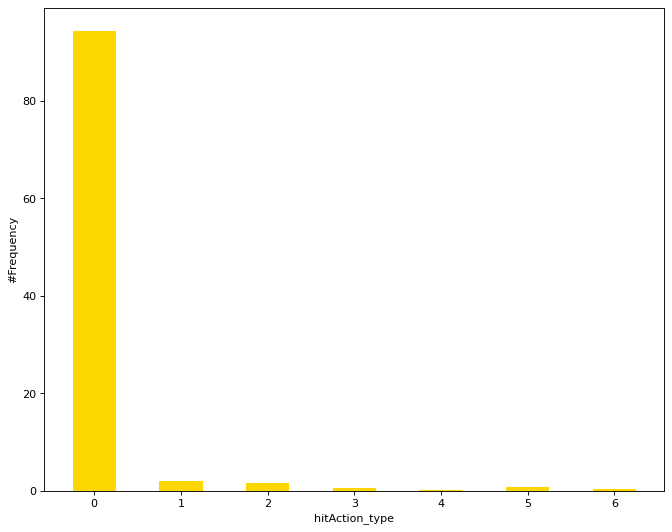

In [29]:
## เห็นว่าตัวแปร hitAction_type ซึ่งอาจจะนำไปเป็น target variable ได้นั้น มีความเป็น imbalance class ค่อนข้างสูง

## Ploting Bars Chart
plt.figure(figsize=(10,8), dpi= 80)
plt.bar(hitAction_type_pd['hitAction_type'], hitAction_type_pd['percentage'], color='gold', width=.5)

## Decoration
plt.ylabel('#Frequency')
plt.xlabel('hitAction_type')


In [30]:
freq_distribution_col_list = ['hitAction_type','hitHour','hitMin','productListName'\
                              ,'v2ProductName']

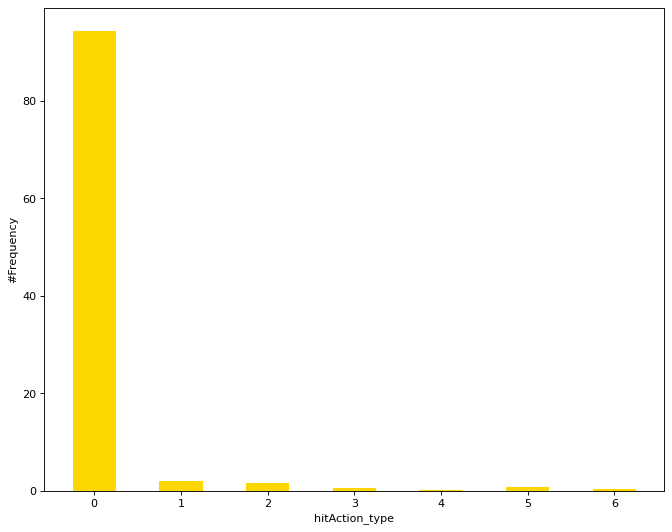

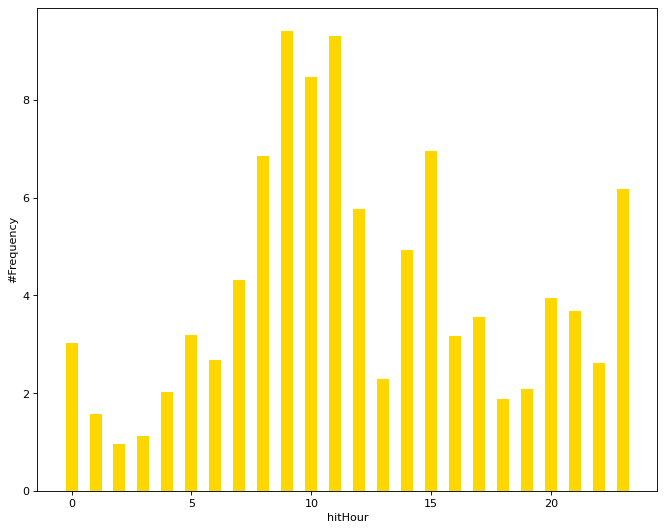

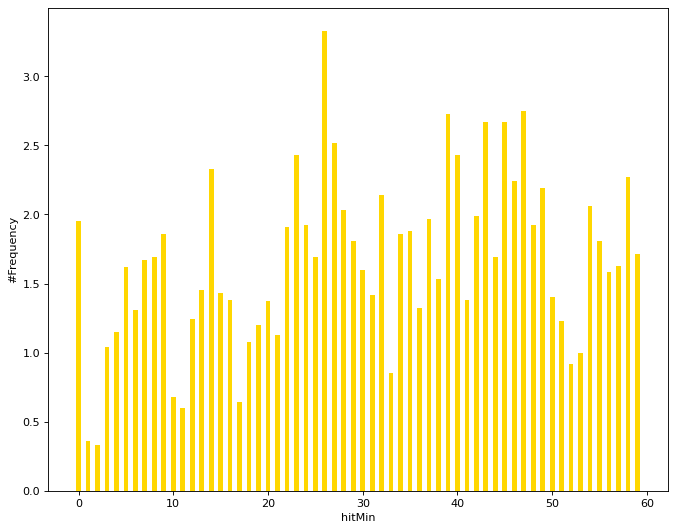

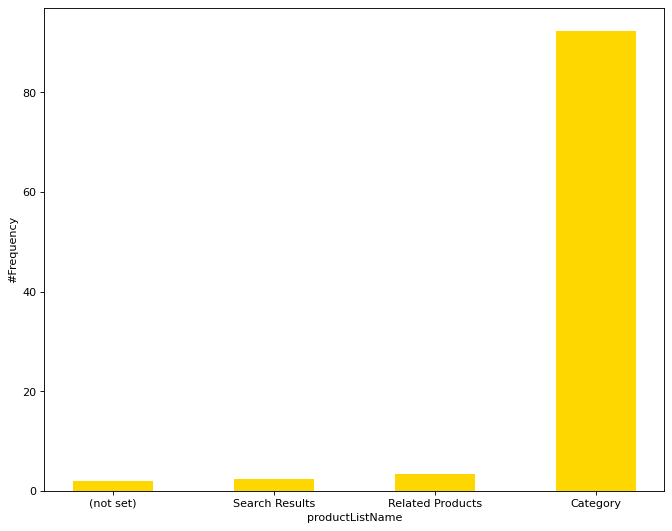

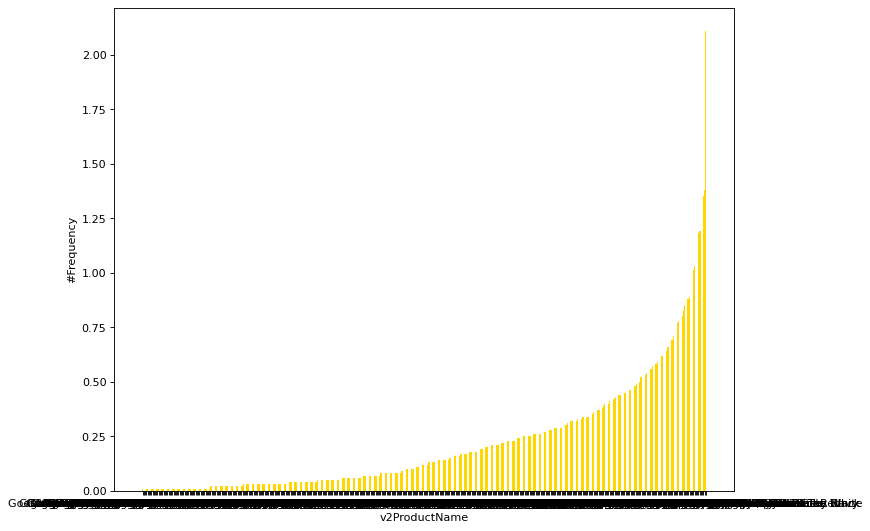

In [31]:
for col in freq_distribution_col_list:
  analysis_pd = raw_df.groupBy(col).count().withColumn('percentage',calPercentfunc(sparkf.col('count')))\
                  .orderBy('percentage')\
                  .toPandas()
  analysis_pd

  ## Ploting Bars Chart
  plt.figure(figsize=(10,8), dpi= 80)
  plt.bar(analysis_pd[col], analysis_pd['percentage'], color='gold', width=.5)

  ## Decoration
  plt.ylabel('#Frequency')
  plt.xlabel(col)

  del(analysis_pd)

### 2.2.2 Multivariate Analysis for Feature Selection/Removal

In [32]:
### เพื่อจะทำ Feature Selection ผมอยากจะหยิบ Feature กับ Label คู่หนึ่งมาทดสอบ
### ด้วยวิธีการ Plot Graph (Viz.)ในแบบ Histogram 

In [33]:
### ในที่นี้หยิบ timeOnsite กับ Label มาทดสอบ

In [34]:
raw_df

DataFrame[source: string, isTrueDirect: boolean, sourceKeyword: string, medium: string, isVideoAd: boolean, fullVisitorId: bigint, visitId: int, date: int, newVisits: int, hitType: string, hitAction_type: int, hitNumber: int, hitHour: int, hitMin: int, timeMicroSec: int, v2ProductName: string, productListName: string, isClick: boolean, isImpression: boolean, timeOnSite: int, totalTransactionRevenue: int]

In [35]:
raw_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: boolean (nullable = true)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: boolean (nullable = true)
 |-- isImpression: boolean (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransactionRevenue: integer (nullable = true)



In [36]:
tos_df = raw_df.select('timeOnsite','totalTransactionRevenue')\
.withColumn('label',sparkf.when(sparkf.col('totalTransactionRevenue').isNull()\
                                ,'not_buy').otherwise('buy'))

In [37]:
tos_pd = tos_df.toPandas()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


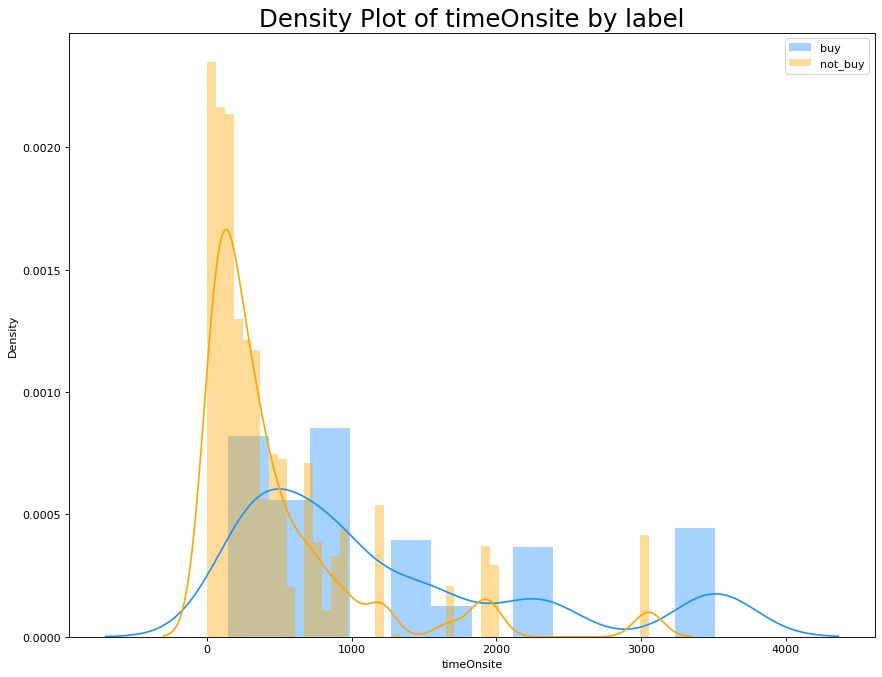

In [38]:
# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(tos_pd.loc[tos_pd.label=='buy', "timeOnsite"], color="dodgerblue", label="buy")
sns.distplot(tos_pd.loc[tos_pd.label=='not_buy', "timeOnsite"], color="orange", label="not_buy")

# Decoration
plt.title('Density Plot of timeOnsite by label', fontsize=22)
plt.legend()
plt.show()

### 2.3 การตรวจพบ Spurious Pattern ด้วย Multivariate Analysis

In [39]:
###โค้ดด้านล่างนี้แสดงให้เห็นว่ามี Spurious Pattern ซึ่งหมายถึง ความสัมพันธ์ระหว่าง Feature กับ Label 
### ที่ยังไม่เหมาะกับการนำไปเป็น Training set ตอนนี้
raw_df.select(['hitAction_type','totalTransactionRevenue'])\
.groupBy('hitAction_type','totalTransactionRevenue')\
.count()\
.orderBy(sparkf.col('hitAction_type').desc(),sparkf.col('count').desc()).show(100)

+--------------+-----------------------+-----+
|hitAction_type|totalTransactionRevenue|count|
+--------------+-----------------------+-----+
|             6|               59960000|    6|
|             6|               30980000|    4|
|             6|               29980000|    4|
|             6|              116760000|    4|
|             6|               33180000|    4|
|             6|               36980000|    4|
|             6|               34590000|    2|
|             6|               28190000|    2|
|             6|               33990000|    2|
|             6|              128970000|    2|
|             6|               23990000|    2|
|             6|               50790000|    2|
|             6|               20580000|    2|
|             5|               29980000|   10|
|             5|               33180000|    8|
|             5|              116760000|    8|
|             5|               36980000|    8|
|             5|                   null|    6|
|            

# 3. Data Preparation

In [40]:
# เราจะแก้ไข Spurious Pattern ก่อนจะกลับมา Feature Selection/Removal อีกครั้ง

### 3.1 Reduce Spurious Pattern

### 3.1.1 Define Window Partitions

In [41]:
## สร้าง Window Partitions สำหรับแบ่งช่วงข้อมูล ด้วย Window 
## กรณีนี้เป็นการแบ่งช่วงข้อมูลตาม fullVisitorId ร่วมกับ VisitId

In [42]:
### กำหนดขอบเขตของ Partition of Rows
sessionWindow = W.partitionBy('fullVisitorId','visitId')\
.orderBy(sparkf.col("hitNumber").cast("long"),sparkf.col('timeMicroSec').cast('long'))\
                 .rangeBetween(-sys.maxsize, sys.maxsize)

### 3.3.3 Declare Aggregation functions

In [43]:
### ประกาศฟังก์ชั่นที่ใช้ นับจำนวน hitAction_type ทั้งหมด
num_HitAction_type = sparkf.expr("count('hitAction_type')")

In [44]:
### ประกาศฟังก์ชั่นที่ใช้ Extract hitAction_type ตัวสุดท้ายออกมา
Get_lastHitAction_Type = sparkf.last(sparkf.col('hitAction_type').cast(IntegerType()))

In [45]:
#ได้ session_df ซึ่งมี 1 row บรรจุ information ของทั้ง Session ไว้ - Spurious Pattern หายไปแล้ว
new_session_df = raw_df.withColumn('numHitAction_type',num_HitAction_type.over(sessionWindow))\
.withColumn('lastHitAction_type',Get_lastHitAction_Type.over(sessionWindow))\
.select('fullVisitorId','VisitId','numHitAction_type','lastHitAction_type')\
.distinct()


In [46]:
new_session_df.orderBy(sparkf.col('fullVisitorId').asc()\
                       ,sparkf.col('VisitId').asc(),sparkf.col('lastHitAction_type'))\
.show(1000)

+-------------------+----------+-----------------+------------------+
|      fullVisitorId|   VisitId|numHitAction_type|lastHitAction_type|
+-------------------+----------+-----------------+------------------+
|  49898505875812980|1491367151|                2|                 0|
|  49898679051871719|1494605584|               14|                 0|
|  49898679051871719|1494616733|               18|                 0|
|  49898679051871719|1494874385|                1|                 0|
|  49898679051871719|1496681648|               12|                 0|
|  49898679051871719|1496681649|               12|                 0|
| 498878131324403508|1483764178|               12|                 0|
| 498880063107182717|1485625044|               36|                 0|
| 498905464420111059|1473189127|              147|                 0|
| 498964599393241343|1498945637|               10|                 0|
| 498979133020437362|1500661019|               12|                 0|
| 499016873304988410

In [47]:
new_session_df.count()

313

In [48]:
raw_df.select('fullVisitorId','visitId').distinct().count()

313

In [49]:
new_session_df.show()

+-------------------+----------+-----------------+------------------+
|      fullVisitorId|   VisitId|numHitAction_type|lastHitAction_type|
+-------------------+----------+-----------------+------------------+
|4990955117732204143|1490136764|               42|                 0|
|4989425631710413740|1484473722|               12|                 0|
|4994662117345585865|1484261089|               24|                 0|
|4995606827430436569|1488143869|               28|                 6|
| 499439897126355128|1476672257|                3|                 0|
|4988812738664327947|1475109955|               34|                 0|
|4991536060599177108|1495501367|               12|                 0|
|4993620301495103843|1494779714|               14|                 2|
|4991515809111534259|1495093015|               12|                 0|
|4988683855814257726|1492045051|               55|                 0|
|4990198874063509353|1477021389|              169|                 0|
|4990384153613853615

In [50]:
partitionCal_df = raw_df.withColumn('numHitAction_type',num_HitAction_type.over(sessionWindow))\
.withColumn('lastHitAction_type',Get_lastHitAction_Type.over(sessionWindow))

In [51]:
partitionCal_df

DataFrame[source: string, isTrueDirect: boolean, sourceKeyword: string, medium: string, isVideoAd: boolean, fullVisitorId: bigint, visitId: int, date: int, newVisits: int, hitType: string, hitAction_type: int, hitNumber: int, hitHour: int, hitMin: int, timeMicroSec: int, v2ProductName: string, productListName: string, isClick: boolean, isImpression: boolean, timeOnSite: int, totalTransactionRevenue: int, numHitAction_type: bigint, lastHitAction_type: int]

In [52]:
partitionCal_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: boolean (nullable = true)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: boolean (nullable = true)
 |-- isImpression: boolean (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransactionRevenue: integer (nullable = true)
 |-- numHitAction_type: long (nullable = false)
 |-- lastHitAction_type: integer (nullable = true

In [53]:
partitionCal_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,9999,None,None,(direct),youtube.com
sourceKeyword,4042,None,None,(not provided),youtube merch
medium,9999,None,None,(none),referral
fullVisitorId,9999,4.5067648825529631E18,1.39995873491150797E18,49898505875812980,4995924842281653133
visitId,9999,1.4850613864552455E9,9020666.664979743,1470106850,1501649190
date,9999,2.016601000310031E7,4694.944823986464,20160801,20170801
newVisits,7269,1.0,0.0,1,1
hitType,9999,None,None,EVENT,PAGE
hitAction_type,9999,0.13831383138313832,0.6864877640641195,0,6


In [54]:
hitAction_type_session_df  = partitionCal_df\
.withColumn('totalTransactionRevenue',sparkf.when(sparkf.col('totalTransactionRevenue').isNull(),0)\
            .otherwise(sparkf.col('totalTransactionRevenue')))\
.groupBy([
 'fullVisitorId',\
 'visitId',\
 'numHitAction_type'\
    ,'lastHitAction_type'\
]).agg(sparkf.collect_list('hitAction_type')\
       ,sparkf.max('totalTransactionRevenue').alias('max_totalTransactionRevenue'))

In [55]:
## นับจำนวน row/observation ของผลลัพธ์จากการทำ .groupBy() with .agg()
hitAction_type_session_df.count()

313

In [56]:
## ตรวจสอบว่า combination of fullVistorId, visitId มี cardinality จำนวนเท่าใด
raw_df.select( 'fullVisitorId',\
 'visitId').distinct().count()

313

In [57]:
raw_df.count()

9999

In [58]:
hitAction_type_session_df.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- numHitAction_type: long (nullable = false)
 |-- lastHitAction_type: integer (nullable = true)
 |-- collect_list(hitAction_type): array (nullable = false)
 |    |-- element: integer (containsNull = false)
 |-- max_totalTransactionRevenue: integer (nullable = true)



In [59]:
hitAction_type_session_df.filter(sparkf.col('max_totalTransactionRevenue')>0).take(10)

[Row(fullVisitorId=4995606827430436569, visitId=1488143869, numHitAction_type=28, lastHitAction_type=6, collect_list(hitAction_type)=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 3, 5, 5, 5, 6, 6], max_totalTransactionRevenue=20580000),
 Row(fullVisitorId=4988683855814257726, visitId=1492045051, numHitAction_type=55, lastHitAction_type=0, collect_list(hitAction_type)=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0], max_totalTransactionRevenue=50790000),
 Row(fullVisitorId=4990198874063509353, visitId=1477021389, numHitAction_type=169, lastHitAction_type=0, collect_list(hitAction_type)=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [60]:
### ประกาศฟังก์ชั่นสำหรับทำ Deduplicated element ของ list
def py_DedupList(seq):
    seen = []
    result = []
    for x in seq:
      #print(x)
      if not(x in seen):
        try:
          if x != result[-1]:
            seen.append(x)
            #print('first',seen,'\n')
        except:
          seen.append(x)
          #print('second',seen,'\n')
        result.append(x)
      else:
        try:
          if x != result[-1]:
            result.append(x)
        except:
          result.append(x)
          #print('second_last',seen,'\n')

    return result
Spark_Deduplist_type = sparkf.udf(lambda x: py_DedupList(x),ArrayType(IntegerType()))

In [61]:
### ประกาศฟังก์ชั่นสำหรับสร้าง label - "buy", "not_buy"
def py_make_label(origi_a):
    if origi_a > 0:
        result_a = 'buy'
    else:
        result_a = 'not_buy'
    
    return result_a

spark_make_label = sparkf.udf(lambda a: py_make_label(a))

In [62]:
### ประกาศฟังก์ชั่นสำหรับตรวจสอบ argument ที่รับมานั่นเป็นเลข 6 หรือไม่
is_completePurchase = lambda x: x == 6

In [63]:
### ประกาศฟังก์ชั่นสำหรับเปลี่ยนเป็น String
spark_toString = sparkf.udf(lambda x: x, StringType())

In [64]:
hitAction_type_session_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,313,4.3810734822723041E18,1.55701158219550106E18,49898505875812980,4995924842281653133
visitId,313,1.4880686929808307E9,8696164.878413878,1470106850,1501649190
numHitAction_type,313,31.945686900958467,40.0227530110204,1,257
lastHitAction_type,313,0.4281150159744409,1.3090324620607872,0,6
max_totalTransactionRevenue,313,2009392.9712460064,1.1828056468526127E7,0,128970000


In [65]:
labelingFutureRemove_df = hitAction_type_session_df\
.withColumn('DedupListHitAction_type',Spark_Deduplist_type(sparkf.col('collect_list(hitAction_type)')))\
.withColumn("no6DeDupHitAction_type", sparkf.expr("filter(DedupListHitAction_type, x -> not(x <=> 6))"))\
.withColumn('all_6',sparkf.filter(sparkf.col('DedupListHitAction_type'),is_completePurchase))\
.withColumn('label',spark_make_label(sparkf.col('max_totalTransactionRevenue')))

In [66]:
labelingFutureRemove_df.filter(sparkf.col('max_totalTransactionRevenue')>0).take(10)

[Row(fullVisitorId=4995606827430436569, visitId=1488143869, numHitAction_type=28, lastHitAction_type=6, collect_list(hitAction_type)=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 3, 5, 5, 5, 6, 6], max_totalTransactionRevenue=20580000, DedupListHitAction_type=[0, 2, 1, 3, 5, 6], no6DeDupHitAction_type=[0, 2, 1, 3, 5], all_6=[6], label='buy'),
 Row(fullVisitorId=4988683855814257726, visitId=1492045051, numHitAction_type=55, lastHitAction_type=0, collect_list(hitAction_type)=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0], max_totalTransactionRevenue=50790000, DedupListHitAction_type=[0, 1, 2, 3, 2, 1, 0, 5, 6, 0], no6DeDupHitAction_type=[0, 1, 2, 3, 2, 1, 0, 5, 0], all_6=[6], label='buy'),
 Row(fullVisitorId=4990198874063509353, visitId=1477021389, numHitAction_type=169, lastHitAction_type=0, collect_list(hitAction_type)=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [67]:
labelingFutureRemove_df.count()

313

In [68]:
crunched_df = labelingFutureRemove_df

In [69]:
crunched_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,313,4.3810734822723041E18,1.55701158219550106E18,49898505875812980,4995924842281653133
visitId,313,1.4880686929808307E9,8696164.878413878,1470106850,1501649190
numHitAction_type,313,31.945686900958467,40.0227530110204,1,257
lastHitAction_type,313,0.4281150159744409,1.3090324620607872,0,6
max_totalTransactionRevenue,313,2009392.9712460064,1.1828056468526127E7,0,128970000
label,313,None,None,buy,not_buy


In [70]:
crunched_df.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- numHitAction_type: long (nullable = false)
 |-- lastHitAction_type: integer (nullable = true)
 |-- collect_list(hitAction_type): array (nullable = false)
 |    |-- element: integer (containsNull = false)
 |-- max_totalTransactionRevenue: integer (nullable = true)
 |-- DedupListHitAction_type: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- no6DeDupHitAction_type: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- all_6: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- label: string (nullable = true)



In [71]:
### get ABT!
final_df = crunched_df.withColumn('no6DeDupHitAction_typeStr'\
                                  , spark_toString(sparkf.col('no6DeDupHitAction_type')))

In [72]:
final_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,313,4.3810734822723041E18,1.55701158219550106E18,49898505875812980,4995924842281653133
visitId,313,1.4880686929808307E9,8696164.878413878,1470106850,1501649190
numHitAction_type,313,31.945686900958467,40.0227530110204,1,257
lastHitAction_type,313,0.4281150159744409,1.3090324620607872,0,6
max_totalTransactionRevenue,313,2009392.9712460064,1.1828056468526127E7,0,128970000
label,313,None,None,buy,not_buy
no6DeDupHitAction_typeStr,313,None,None,"[0, 1, 2, 0, 1, 2, 1, 2, 0, 1, 2, 3, 0, 2, 1, ...",[4]


In [73]:
final_df.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- numHitAction_type: long (nullable = false)
 |-- lastHitAction_type: integer (nullable = true)
 |-- collect_list(hitAction_type): array (nullable = false)
 |    |-- element: integer (containsNull = false)
 |-- max_totalTransactionRevenue: integer (nullable = true)
 |-- DedupListHitAction_type: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- no6DeDupHitAction_type: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- all_6: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- label: string (nullable = true)
 |-- no6DeDupHitAction_typeStr: string (nullable = true)



# 4. Modeling

In [74]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=49)
print("Training Dataset: " + str(train_df.count()))
print("Testing Dataset: " + str(test_df.count()))

Training Dataset: 253
Testing Dataset: 60


In [75]:
label_stringIndexer = StringIndexer(inputCol = 'label', outputCol = 'label_indexed')

seq_hitActionType_stringIndexer = StringIndexer(handleInvalid = 'keep',inputCol = 'no6DeDupHitAction_typeStr'\
                                                , outputCol = 'seq_hitActionType_indexed')

seq_hitActionType_oneHotEncoder = OneHotEncoder(inputCol='seq_hitActionType_indexed'\
                                                , outputCol='seq_hitActionType_encoded')

In [76]:
vector_assembler = VectorAssembler\
(handleInvalid = "skip", \
 inputCols = [\
              'seq_hitActionType_encoded'\
              ,'numHitAction_type'
             ], outputCol = 'features')

In [77]:
algo = RandomForestClassifier(labelCol='label_indexed', featuresCol='features')

In [78]:
ABTtoModel_pipeline = Pipeline(stages=[label_stringIndexer, seq_hitActionType_stringIndexer\
                                      , seq_hitActionType_oneHotEncoder, vector_assembler,algo])

In [79]:
mlModel = ABTtoModel_pipeline.fit(train_df)

# 5. Model Evaluation

In [80]:
result_df = mlModel.transform(test_df)

In [81]:
test_df.columns

['fullVisitorId',
 'visitId',
 'numHitAction_type',
 'lastHitAction_type',
 'collect_list(hitAction_type)',
 'max_totalTransactionRevenue',
 'DedupListHitAction_type',
 'no6DeDupHitAction_type',
 'all_6',
 'label',
 'no6DeDupHitAction_typeStr']

In [82]:
result_df.columns

['fullVisitorId',
 'visitId',
 'numHitAction_type',
 'lastHitAction_type',
 'collect_list(hitAction_type)',
 'max_totalTransactionRevenue',
 'DedupListHitAction_type',
 'no6DeDupHitAction_type',
 'all_6',
 'label',
 'no6DeDupHitAction_typeStr',
 'label_indexed',
 'seq_hitActionType_indexed',
 'seq_hitActionType_encoded',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [83]:
result_df.select('label','label_indexed','prediction').show()

+-------+-------------+----------+
|  label|label_indexed|prediction|
+-------+-------------+----------+
|not_buy|          0.0|       0.0|
|    buy|          1.0|       0.0|
|    buy|          1.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|    buy|          1.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
|not_buy|          0.0|       0.0|
+-------+-------------+----------+
only showing top 20 rows



In [84]:
result_df.groupBy('label','label_indexed','prediction')\
.count()\
.orderBy('label',sparkf.col('prediction').desc()).show()

+-------+-------------+----------+-----+
|  label|label_indexed|prediction|count|
+-------+-------------+----------+-----+
|    buy|          1.0|       0.0|    5|
|not_buy|          0.0|       1.0|    1|
|not_buy|          0.0|       0.0|   54|
+-------+-------------+----------+-----+



In [85]:
positive_side = 'buy' ### positive_side = 1.0

In [86]:
##TP
TP = result_df.filter(sparkf.col('prediction') \
                 == sparkf.col('label_indexed')).\
filter(sparkf.col('label') == positive_side).count()

##FN
FN = result_df.filter(sparkf.col('prediction') \
                 != sparkf.col('label_indexed')).\
filter(sparkf.col('label') == positive_side).count()

##TN
TN = result_df.filter(sparkf.col('prediction') \
                 == sparkf.col('label_indexed')).\
filter(sparkf.col('label') != positive_side).count()

##FP
FP = result_df.filter(sparkf.col('prediction') \
                 != sparkf.col('label_indexed')).\
filter(sparkf.col('label') != positive_side).count()

In [87]:
print('TP: ',TP);print('FN: ',FN);print('TN: ',TN);print('FP: ',FP)

TP:  0
FN:  5
TN:  54
FP:  1


In [88]:
TPR = TP/(TP+FN)
FNR = FN/(TP+FN)

TNR = TN/(TN+FP)
FPR = FP/(TN+FP)

ACC = (TP+TN)/(TP+TN+FP+FN)

In [89]:
print('TPR: ',TPR);print('FNR: ',FNR);print('TNR: ',TNR);print('FPR: ',FPR);print('ACC: ', ACC)

TPR:  0.0
FNR:  1.0
TNR:  0.9818181818181818
FPR:  0.01818181818181818
ACC:  0.9


In [90]:
## Feature Importance

In [91]:
featureImportances = mlModel.stages[4].featureImportances.toArray()

In [92]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [93]:
ExtractFeatureImp(featureImportances, result_df, "features").head(30)

,idx,name,score
16,15,"seq_hitActionType_encoded_[0, 1, 2, 1, 0, 3, 5]",0.218093
36,35,"seq_hitActionType_encoded_[0, 2, 1, 3, 5]",0.138913
23,22,"seq_hitActionType_encoded_[0, 1, 2, 3, 0, 1, 2...",0.138560
38,37,"seq_hitActionType_encoded_[0, 3, 5]",0.110690
15,14,"seq_hitActionType_encoded_[0, 1, 2, 1, 0, 3, 0...",0.109013
24,23,"seq_hitActionType_encoded_[0, 1, 2, 3, 0, 3, 0...",0.108630
30,29,"seq_hitActionType_encoded_[0, 2, 1, 0, 3, 0, 1...",0.053179
9,8,"seq_hitActionType_encoded_[0, 1, 2, 3, 5]",0.047536
1,0,seq_hitActionType_encoded_[0],0.042543
0,44,numHitAction_type,0.030784
